In [1]:
import pandas as pd
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import dash
from dash import dcc, html
import dash_bootstrap_components as dbc
import json as js
# Set a compatible renderer
pio.renderers.default = 'browser'  # Opens the chart in your default web browser
style_head = f'style="font-size: 32px; font-family: Helvetica"'
alpha = 0.05

In [2]:
world_cup_df = pd.read_csv('../data/matches_world_cup.csv')
world_cup_df.head()

,id,home_team,away_team,result_full,goal_home_ft,home_fouls_conceded,away_fouls_conceded,home_shots_on_target,away_shots_on_target
0,1,QAT,ECU,0-2,-2,NaN,NaN,NaN,NaN
1,2,ENG,IRN,6-2,4,12.0,9.0,13.0,8.0
2,3,SEN,NED,0-2,-2,13.0,13.0,14.0,9.0
3,4,USA,WAL,1-1,0,9.0,14.0,6.0,7.0
4,5,ARG,KSA,1-2,-1,21.0,6.0,14.0,3.0


In [3]:
df = pd.read_csv('../data/df_full_premierleague.csv')
df.head()

,Unnamed: 0,link_match,season,date,home_team,away_team,result_full,result_ht,home_clearances,home_corners,...,tackles_avg_away,touches_avg_away,yellow_cards_avg_away,goals_scored_ft_avg_away,goals_conced_ft_avg_away,sg_match_ft_acum_away,goals_scored_ht_avg_away,goals_conced_ht_avg_away,sg_match_ht_acum_away,performance_acum_away
0,0,https://www.premierleague.com/match/7186,10/11,2010-11-01,Blackpool,West Bromwich Albion,2-1,1-0,15.0,8.0,...,20.0,584.9,1.6,1.44,1.67,-2.0,0.33,0.78,-4.0,55.6
1,1,https://www.premierleague.com/match/7404,10/11,2011-04-11,Liverpool,Manchester City,3-0,3-0,16.0,6.0,...,22.0,681.4,2.0,1.61,0.87,23.0,0.87,0.32,17.0,60.2
2,2,https://www.premierleague.com/match/7255,10/11,2010-12-13,Manchester United,Arsenal,1-0,1-0,26.0,5.0,...,21.2,748.0,1.8,2.12,1.12,16.0,0.94,0.38,9.0,66.7
3,3,https://www.premierleague.com/match/7126,10/11,2010-09-13,Stoke City,Aston Villa,2-1,0-1,26.0,8.0,...,25.0,567.3,2.0,1.33,2.00,-2.0,1.00,1.00,0.0,66.7
4,4,https://www.premierleague.com/match/7350,10/11,2011-02-14,Fulham,Chelsea,0-0,0-0,50.0,4.0,...,19.4,728.6,1.4,1.84,0.88,24.0,0.84,0.48,9.0,58.7


In [4]:
# join the two dataframes , by union them together
#df = pd.concat([df, world_cup_df], axis=0)

In [5]:
def fig_to_json_file(fig, filename):
    fig_json = fig.to_json()
    with open(f'../graphs/{filename}.json', mode='w') as f:
        
        f.write(js.dumps(js.loads(fig_json), indent=2))


In [6]:
# Create the 'result' column
def determine_result(row):
    if row['goal_home_ft'] > row['goal_away_ft']:
        return 'HW'  # Home Win
    elif row['goal_home_ft'] < row['goal_away_ft']:
        return 'AW'  # Away Win
    else:
        return 'D'   # Draw

# Apply the function to each row
df['result'] = df.apply(determine_result, axis=1)

### Anova test
Anova test is used to compare the means of more than two groups. It is an extension of the t-test. The null hypothesis is that all groups have the same mean. The alternative hypothesis is that at least one group has a different mean. The test statistic is the F-statistic. The p-value is the probability of observing the data given that the null hypothesis is true. If the p-value is less than the significance level, we reject the null hypothesis.

In [7]:


# Calculate win probabilities
home_wins = df[df['result'] == 'HW'].shape[0]
away_wins = df[df['result'] == 'AW'].shape[0]
total_matches = df.shape[0]

home_win_prob = home_wins / total_matches
away_win_prob = away_wins / total_matches

# Create a DataFrame with probabilities for ANOVA
anova_df = pd.DataFrame({
    'Type': ['Home', 'Away'],
    'Probability': [home_win_prob, away_win_prob]
})

# Perform ANOVA
f_stat, p_value = f_oneway([home_win_prob] * home_wins, [away_win_prob] * away_wins)
title = f"F-statistic: {f_stat}, P-value: {p_value}"
sig = p_value < alpha
description = f'' 
print(title)
if p_value < alpha:
    description = "There is a significant difference in the probability of winning between Home and Away teams."
else:
    description = "There is no significant difference in the probability of winning between Home and Away teams."
print(description)

F-statistic: inf, P-value: 0.0
There is a significant difference in the probability of winning between Home and Away teams.


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/stats/_stats_py.py:3906: ConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



In [8]:
# This is in plotly and show in the browser
# Count occurrences of each result
result_counts = df['result'].value_counts().reset_index()
result_counts.columns = ['Result', 'Count']

# Create a Plotly pie chart
fig = px.pie(result_counts, 
             values='Count', 
             names='Result', 
             title=f'''<span >Match Result Distribution</span><br>{title}<br><sub>{description}</sub>''', 
             hole=0.3)  # Set hole > 0 for a donut chart

fig.show()
fig_to_json_file(fig, 'match_result_distribution')

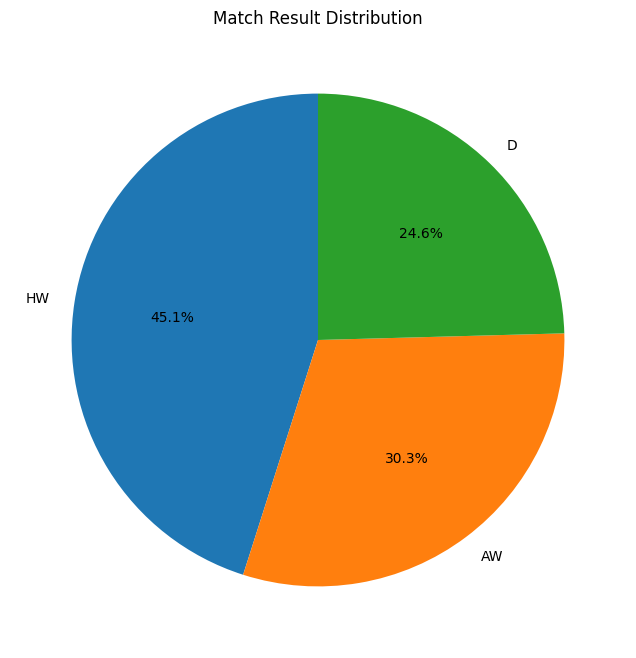

In [9]:
# Count occurrences of each result
result_counts = df['result'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Match Result Distribution')
plt.show()


### Fouls conceded by players
* we wanted to check if there is a relationship between the number of fouls conceded by players to the team winning chances.


In [10]:
# Group by fouls conceded and calculate metrics
fouls_analysis = df.groupby('home_fouls_conceded').agg(
    matches=('result', 'count'),
    home_wins=('result', lambda x: (x == 'HW').sum()),
    avg_goal_difference=('sg_match_ft', 'mean')
).reset_index()

# Calculate win probability
fouls_analysis['win_probability'] = fouls_analysis['home_wins'] / fouls_analysis['matches']

# View the analysis DataFrame
# Correlation between fouls and win probability
corr_fouls_win_prob, p_value1 = pearsonr(fouls_analysis['home_fouls_conceded'], fouls_analysis['win_probability'])

# Correlation between fouls and goal difference
corr_fouls_goal_diff, p_value2 = pearsonr(fouls_analysis['home_fouls_conceded'], fouls_analysis['avg_goal_difference'])

print(f"Correlation between fouls and win probability: {corr_fouls_win_prob} (p-value: {p_value1})")
print(f"Correlation between fouls and goal difference: {corr_fouls_goal_diff} (p-value: {p_value2})")
if p_value2 < alpha:
    description = "There is a significant correlation between fouls conceded and average winning chances."
else:
    description = "There is no significant correlation between fouls conceded and average winning chances."


Correlation between fouls and win probability: 0.06761482323642753 (p-value: 0.7481090698143276)
Correlation between fouls and goal difference: 0.10789812523824376 (p-value: 0.607689951153228)


In [11]:
# Calculate total fouls for each goal difference
fouls_vs_goal_diff = df.groupby('sg_match_ft').agg(
    total_fouls=('home_fouls_conceded', 'sum'),
    total_matches=('sg_match_ft', 'count')
).reset_index()

# Plot total fouls vs. goal difference
fig = px.bar(fouls_vs_goal_diff,
             x='sg_match_ft',
             y='total_fouls',
             title=f'<span {style_head}>Total Fouls vs. Goal Difference</span><br>{description}',
             labels={'sg_match_ft': 'Goal Difference', 'total_fouls': 'Total Fouls'},
             text='total_fouls')

# Add a line chart for total matches to give context (optional)
fig.update_traces(textposition='outside')
fig.update_layout(xaxis=dict(title='Goal Difference (sg_match_ft)'),
                  yaxis=dict(title='Total Fouls'),
                  showlegend=False)
fig.show()
fig_to_json_file(fig, 'total_fouls_vs_goal_diff')

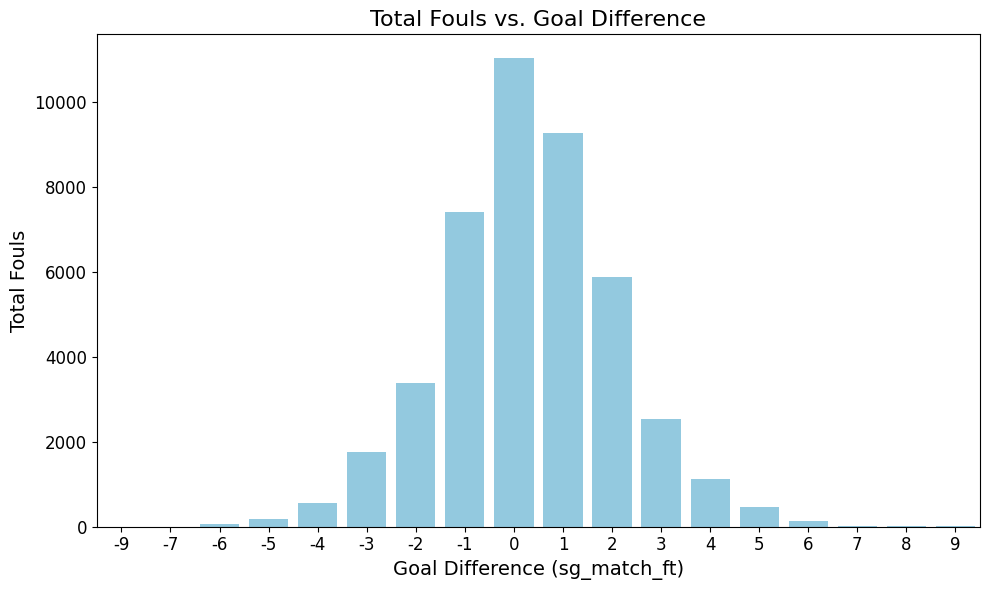

In [12]:
# Create the Seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='sg_match_ft', 
    y='total_fouls', 
    data=fouls_vs_goal_diff, 
    color='skyblue'
)

# Add titles and labels
plt.title('Total Fouls vs. Goal Difference', fontsize=16)
plt.xlabel('Goal Difference (sg_match_ft)', fontsize=14)
plt.ylabel('Total Fouls', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


### Possession of the ball to the team winning chances
* we wanted to check if there is a relationship between the possession of the ball to the team winning chances.

In [13]:
# Filter possession data based on match outcome
home_win_possession = df[df['result'] == 'HW']['home_possession'].dropna()
away_win_possession = df[df['result'] == 'AW']['away_possession'].dropna()
draw_home_possession = df[df['result'] == 'D']['away_possession'].dropna()
# list(draw_home_possession)
# Perform ANOVA test
f_stat, p_value = f_oneway(home_win_possession, away_win_possession)
title = f"F-statistic: {f_stat:.3f}, P-value: {p_value:.4f}"
description = f'' 
print(title)
if p_value < alpha:
    description = "There is a significant difference in possession percentages between match outcomes."
else:
    description = "There is no significant difference in possession percentages between match outcomes."
print(description)

F-statistic: 13.933, P-value: 0.0002
There is a significant difference in possession percentages between match outcomes.


In [14]:
# Define bins for possession percentage
bins = np.arange(0, 101, 5)  # Create bins from 0% to 100% in increments of 5
df['possession_bin'] = pd.cut(df['home_possession'], bins, right=False)

# Calculate total games and wins for each possession bin
game_data = df.groupby('possession_bin').size().reset_index(name='total_games')
win_data = df[df['result'] == 'HW'].groupby('possession_bin').size().reset_index(name='home_wins')

# Merge the two DataFrames
data = pd.merge(game_data, win_data, on='possession_bin', how='left')
data['home_wins'] = data['home_wins'].fillna(0)  # Replace NaN with 0 for bins with no wins

# Calculate the win rate
data['win_rate'] = data['home_wins'] / data['total_games']

# Convert bin intervals to numeric (midpoints) for plotting
data['possession_mid'] = data['possession_bin'].apply(lambda x: x.mid)

/var/folders/27/h86gj_fd3xg23kmxw_95c6kc0000gn/T/ipykernel_3927/82229308.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/27/h86gj_fd3xg23kmxw_95c6kc0000gn/T/ipykernel_3927/82229308.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [15]:
data.dropna(subset=['win_rate'], inplace=True)

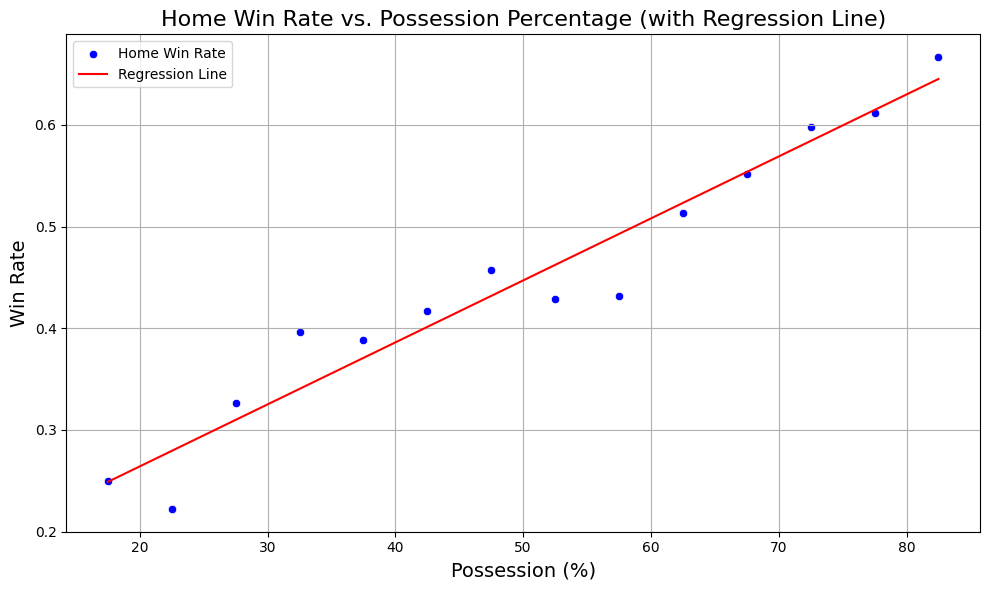

Regression equation: y = 0.0061x + 0.1424


In [16]:
# Prepare data for regression
X = data['possession_mid'].values.reshape(-1, 1)  # Reshape for sklearn
y = data['win_rate'].values

# Fit a linear regression model
reg_model = LinearRegression()
reg_model.fit(X, y)

# Predict the regression line
data['regression_line'] = reg_model.predict(X)

# Plot scatter plot with regression line
plt.figure(figsize=(10, 6))

sns.scatterplot(data=data, x='possession_mid', y='win_rate', label='Home Win Rate', color='blue')
sns.lineplot(data=data, x='possession_mid', y='regression_line', label='Regression Line', color='red')

# Customize the plot
plt.title(f'Home Win Rate vs. Possession Percentage (with Regression Line)', fontsize=16)
plt.xlabel('Possession (%)', fontsize=14)
plt.ylabel('Win Rate', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print regression equation
print(f"Regression equation: y = {reg_model.coef_[0]:.4f}x + {reg_model.intercept_:.4f}")

In [17]:
# Create the Plotly figure
fig = go.Figure()

# Scatter plot for win rates
fig.add_trace(go.Scatter(
    x=data['possession_mid'],
    y=data['win_rate'],
    mode='markers',
    name='Home Win Rate',
    marker=dict(color='blue')
))

# Add the regression line
fig.add_trace(go.Scatter(
    x=data['possession_mid'],
    y=data['regression_line'],
    mode='lines',
    name='Regression Line',
    line=dict(color='red', width=2)
))

fig.update_layout(
    title=f'<span {style_head}>Home Win Rate vs. Possession Percentage</span><br>{title}<br><sub>{description}</sub>',
    xaxis_title='Possession (%)',
    yaxis_title='Win Rate',
    legend=dict(x=0.1, y=0.9),
    template='plotly_white'
)
fig.show()
fig_to_json_file(fig, 'home_win_rate_vs_possession')

### Clearances and shots made by players
* we are checking the relationship between the number of clearances and shots made by players to the team winning chances.


### difference between the shots among the home and away team and the winning chances

In [18]:
# difference between the shots among the home and away team and the winning team
df['home_shots_diff'] = df['home_shots_on_target'] - df['away_shots_on_target']
# Group by the number of shots
shots_diff_data = df.groupby('home_shots_diff').agg(
    total_games=('result', 'size'),
    wins=('result', lambda x: (x == 'HW').sum())
).reset_index()
shots_diff_data['win_percentage'] = (shots_diff_data['wins'] / shots_diff_data['total_games']) * 100
shots_data_big_only = shots_diff_data[shots_diff_data['total_games'] > 10]

# 2D Plot: Shots vs Win Percentage
fig_shots = px.scatter(
    shots_data_big_only,
    x='home_shots_diff',
    y='win_percentage',
    size='total_games',
    title='Win Percentage vs Number of Shots difference on Target',
    labels={'home_shots_on_target': 'Number of Shots on Target', 'win_percentage': 'Win Percentage (%)'},
    template='plotly_white',
    trendline='ols'
)
fig_shots.update_traces(mode='lines+markers')
fig_shots.show()
fig_to_json_file(fig_shots, 'shots_diff_vs_win_percentage')

In [19]:
# Group by the number of shots
shots_data = df.groupby('home_shots_on_target').agg(
    total_games=('result', 'size'),
    wins=('result', lambda x: (x == 'HW').sum())
).reset_index()
shots_data['win_percentage'] = (shots_data['wins'] / shots_data['total_games']) * 100

# Group by the number of clearances
clearance_data = df.groupby('home_clearances').agg(
    total_games=('result', 'size'),
    wins=('result', lambda x: (x == 'HW').sum())
).reset_index()
clearance_data['win_percentage'] = (clearance_data['wins'] / clearance_data['total_games']) * 100

# Group by both shots and clearances for 3D visualization
combined_data = df.groupby(['home_shots_diff', 'home_clearances']).agg(
    total_games=('result', 'size'),
    wins=('result', lambda x: (x == 'HW').sum())
).reset_index()
combined_data['win_percentage'] = (combined_data['wins'] / combined_data['total_games']) * 100

In [20]:
shots_data_big_only = shots_data[shots_data['total_games'] > 10]

# 2D Plot: Shots vs Win Percentage
fig_shots = px.scatter(
    shots_data_big_only,
    x='home_shots_on_target',
    y='win_percentage',
    size='total_games',
    title='Win Percentage vs Number of Shots on Target',
    labels={'home_shots_on_target': 'Number of Shots on Target', 'win_percentage': 'Win Percentage (%)'},
    template='plotly_white',
    trendline='ols'
)
fig_shots.update_traces(mode='lines+markers')
fig_shots.show()
fig_to_json_file(fig_shots, 'shots_vs_win_percentage')

In [21]:
# Create bins of 5 for clearances
bins = range(0, int(df['home_clearances'].max()) + 5, 5)  # Ensure max is an integer
clearance_data_binned = df.copy()

# Bin the clearances into intervals of 5
clearance_data_binned['clearance_bin'] = pd.cut(clearance_data_binned['home_clearances'], bins=bins, right=False)

# Group by clearance bins and calculate win percentage
clearance_data_binned = clearance_data_binned.groupby('clearance_bin').agg(
    total_games=('result', 'size'),
    wins=('result', lambda x: (x == 'HW').sum())
).reset_index()
clearance_data_binned['win_percentage'] = (clearance_data_binned['wins'] / clearance_data_binned['total_games']) * 100

# Convert bin intervals to numeric (midpoints) for plotting
clearance_data_binned['clearance_mid'] = clearance_data_binned['clearance_bin'].apply(lambda x: x.mid)
clearance_data_binned_only_big = clearance_data_binned[clearance_data_binned['total_games'] > 10]
# Plot: Clearance Bins vs Win Percentage
fig_clearance_bins = px.scatter(
    clearance_data_binned_only_big,
    x='clearance_mid',
    y='win_percentage',
    size='total_games',
    title='Win Percentage vs Clearance Bins',
    labels={'clearance_mid': 'Clearances (Binned)', 'win_percentage': 'Win Percentage (%)'},
    template='plotly_white',
    # trendline='ols'
)
fig_clearance_bins.update_traces(mode='lines+markers')
fig_clearance_bins.show()
fig_to_json_file(fig_clearance_bins, 'clearance_bins_vs_win_percentage')


/var/folders/27/h86gj_fd3xg23kmxw_95c6kc0000gn/T/ipykernel_3927/3429871383.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [22]:

# Prepare data for regression
X = combined_data[['home_shots_diff', 'home_clearances']].values
y = combined_data['win_percentage'].values

# Fit a regression model
reg_model = LinearRegression()
reg_model.fit(X, y)

# Generate the plane for the regression
xx, yy = np.meshgrid(
    np.linspace(combined_data['home_shots_diff'].min(), combined_data['home_shots_diff'].max(), 20),
    np.linspace(combined_data['home_clearances'].min(), combined_data['home_clearances'].max(), 20)
)
zz = reg_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# 3D Scatter Plot with Regression Plane
fig_3d_with_plane = go.Figure()

# Add scatter points
fig_3d_with_plane.add_trace(go.Scatter3d(
    x=combined_data['home_shots_diff'],
    y=combined_data['home_clearances'],
    z=combined_data['win_percentage'],
    mode='markers',
    marker=dict(size=5, color=combined_data['win_percentage'], colorscale='Viridis'),
    name='Data Points'
))

# Add regression plane
fig_3d_with_plane.add_trace(go.Surface(
    x=xx, y=yy, z=zz,
    colorscale='RdBu',
    opacity=0.5,
    name='Regression Plane'
))

# Customize layout
fig_3d_with_plane.update_layout(
    title='3D Visualization with Regression Plane: Shots, Clearances, and Win Percentage',
    scene=dict(
        xaxis_title='Shots on Target',
        yaxis_title='Clearances',
        zaxis_title='Win Percentage (%)'
    ),
    template='plotly_white'
)

fig_3d_with_plane.show()
fig_to_json_file(fig_3d_with_plane, 'visualization_with_regression_plane_3d_scatter')
# Print regression coefficients
print(f"Regression Equation: z = {reg_model.coef_[0]:.4f} * Shots + {reg_model.coef_[1]:.4f} * Clearances + {reg_model.intercept_:.4f}")

Regression Equation: z = 5.5624 * Shots + 0.5925 * Clearances + 25.7555


In [23]:
clearance_data_binned

,clearance_bin,total_games,wins,win_percentage,clearance_mid
0,"[0, 5)",25,12,48.000000,2.5
1,"[5, 10)",207,75,36.231884,7.5
2,"[10, 15)",505,203,40.198020,12.5
3,"[15, 20)",711,296,41.631505,17.5
4,"[20, 25)",789,331,41.951838,22.5
5,"[25, 30)",631,292,46.275753,27.5
6,"[30, 35)",462,221,47.835498,32.5
7,"[35, 40)",313,157,50.159744,37.5
8,"[40, 45)",199,109,54.773869,42.5
9,"[45, 50)",105,61,58.095238,47.5
